import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u

dataset

In [2]:
file_path = "./supernova_data.dat"

read data

In [8]:
supernova_df = pd.read_csv(file_path, delim_whitespace=True, comment='#')

Preview Dataset Columns

In [5]:
print("Available columns:", supernova_df.columns.tolist())


Available columns: ['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL', 'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF', 'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c', 'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC', 'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB', 'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b', 'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD']


clean and extract data

In [9]:
required_columns = ['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG']
df = supernova_df.dropna(subset=required_columns)

z = df['zHD'].values
mu_obs = df['MU_SH0ES'].values
mu_err = df['MU_SH0ES_ERR_DIAG'].values

Plot Hubble Diagram

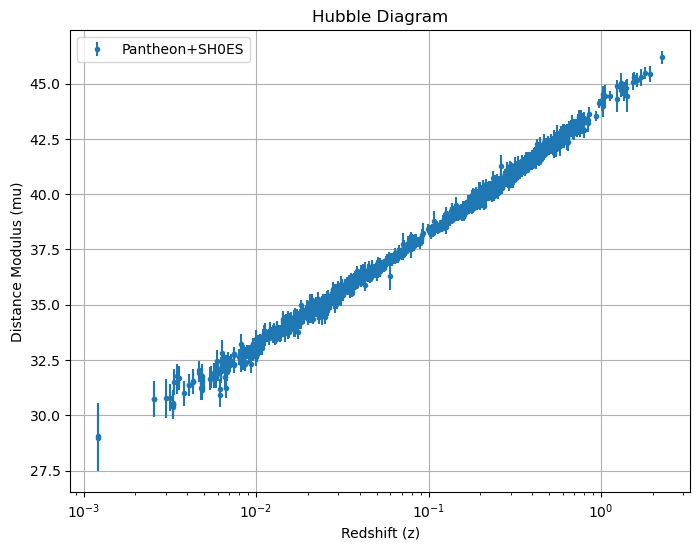

In [14]:
plt.figure(figsize=(8, 6))
plt.errorbar(z, mu_obs, yerr=mu_err, fmt='.', label='Pantheon+SH0ES')
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.title('Hubble Diagram')
plt.grid(True)
plt.legend()
plt.show()

Cosmological Model

In [15]:
def E(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

def luminosity_distance(z, H0, Omega_m):
    integral, _ = quad(lambda z_: 1.0 / E(z_, Omega_m), 0, z)
    dL = (c.to('km/s').value / H0) * (1 + z) * integral
    return dL

def mu_theory(z, H0, Omega_m):
    dL = np.vectorize(luminosity_distance)(z, H0, Omega_m)
    return 5 * np.log10(dL) + 25

Fit the Model to Data

In [17]:
def fit_func(z, H0, Omega_m):
    return mu_theory(z, H0, Omega_m)

p0 = [70, 0.3]
popt, pcov = curve_fit(fit_func, z, mu_obs, sigma=mu_err, p0=p0)
H0_fit, Omega_m_fit = popt
H0_err, Omega_m_err = np.sqrt(np.diag(pcov))

print(f"Fitted H0 = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Omega_m = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")

Fitted H0 = 72.97 ± 0.17 km/s/Mpc
Fitted Omega_m = 0.351 ± 0.012


Age of the Universe

In [18]:
def age_of_universe(H0, Omega_m):
    integrand = lambda z: 1.0 / ((1 + z) * E(z, Omega_m))
    integral, _ = quad(integrand, 0, np.inf)
    H0_si = H0 * u.km / u.s / u.Mpc
    age = integral / H0_si
    return age.to(u.Gyr)

t0 = age_of_universe(H0_fit, Omega_m_fit)
print(f"Estimated age of Universe: {t0:.2f}")

Estimated age of Universe: 12.36 Gyr


Residuals

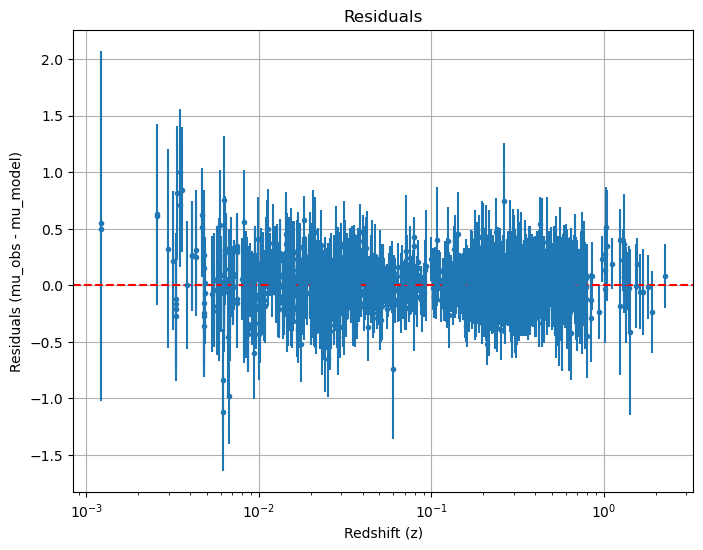

In [22]:
mu_model = mu_theory(z, H0_fit, Omega_m_fit)
residuals = mu_obs - mu_model

plt.figure(figsize=(8, 6))
plt.errorbar(z, residuals, yerr=mu_err, fmt='.')
plt.axhline(0, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals (mu_obs - mu_model)')
plt.title('Residuals')
plt.grid(True)
plt.show()

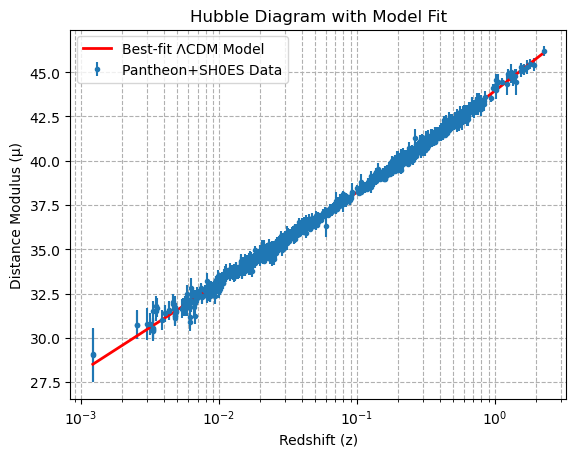

In [30]:
z_sorted = np.sort(z) # To ensure a smooth curve
mu_model_sorted = mu_theory(z_sorted, H0_fit, Omega_m_fit)
plt.errorbar(z, mu_obs, yerr=mu_err, fmt='.', label='Pantheon+SH0ES Data')
plt.plot(z_sorted, mu_model_sorted, color='red', label='Best-fit ΛCDM Model', linewidth=2)
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.title('Hubble Diagram with Model Fit')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig("hubble_diagram_with_fit.png")
plt.show()

Fit with Fixed Omega_m

In [28]:
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)

popt_fixed, pcov_fixed = curve_fit(mu_fixed_Om, z, mu_obs, sigma=mu_err, p0=[70])
H0_fixed = popt_fixed[0]
H0_fixed_err = np.sqrt(np.diag(pcov_fixed))[0]
print(f"Fixed Omega_m=0.3: H0 = {H0_fixed:.2f} ± {H0_fixed_err:.2f} km/s/Mpc")

Fixed Omega_m=0.3: H0 = 73.53 ± 0.11 km/s/Mpc


Compare Low-z and High-z Subsamples

In [29]:
z_split = 0.4
low_mask = z < z_split
high_mask = z >= z_split

# Low-z fit
popt_low, _ = curve_fit(mu_fixed_Om, z[low_mask], mu_obs[low_mask], sigma=mu_err[low_mask], p0=[70])
H0_low = popt_low[0]

# High-z fit
popt_high, _ = curve_fit(mu_fixed_Om, z[high_mask], mu_obs[high_mask], sigma=mu_err[high_mask], p0=[70])
H0_high = popt_high[0]

print(f"Low-z (z < {z_split}): H0 = {H0_low:.2f} km/s/Mpc")
print(f"High-z (z ≥ {z_split}): H0 = {H0_high:.2f} km/s/Mpc")

Low-z (z < 0.4): H0 = 73.35 km/s/Mpc
High-z (z ≥ 0.4): H0 = 74.49 km/s/Mpc
